In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, roc_auc_score,
                            PrecisionRecallDisplay)

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [4]:
%%notify
import time
time.sleep(3)
print('Finished!')

Finished!


<IPython.core.display.Javascript object>

# 1. EDA & Preprocessing

In [5]:
# check directory with %pwd, put data file in that directory
%pwd
# name the columns
colnames = ['Age', 'Employment type', 'Weighting factor', 'Level of education', 'Schooling/training period', 
               'Martial status', 'Employment area', 'Partnership', 'Ethnicity', 'Gender', 'Gains on financial assets',
              'Losses on financial assets', 'Weekly working time', 'Country of birth', 'Income']

# read the data file, set colnames and replace '?' by NaN
data = pd.read_csv('einkommen.train.csv', header=None, names=colnames, sep=',\s', na_values=["?"], engine = 'python')
# replace the 'income' col with 0 (<=50k) and 1 (>50k)
#data = np.where(data['Income'] == '>50k', 1, data['Income'])
#data['Income'].loc[(data['Income'] == '>50k')] = 1
#data = data.loc[(data['Income']) == '<=50k'] = 0
data.loc[data['Income'] == '>50K', 'Income'] = 1
data.loc[data['Income'] == '<=50K', 'Income'] = 0

In [6]:
data.shape

(30000, 15)

In [6]:
# look at N randomly selected rows where N is in the brackets
data.sample(15, random_state = 14)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
6947,37,Self-emp-inc,27997,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,50,United-States,NaN
24408,39,Private,121468,Bachelors,13,Never-married,Exec-managerial,Own-child,Asian-Pac-Islander,Female,0,0,35,United-States,NaN
11085,28,NaN,80165,Some-college,10,Divorced,NaN,Not-in-family,White,Female,0,0,30,United-States,NaN
21625,23,Private,183358,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Puerto-Rico,NaN
3207,23,NaN,123983,Bachelors,13,Never-married,NaN,Own-child,Other,Male,0,0,40,United-States,0
26650,34,Private,287737,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,1485,40,United-States,NaN
16382,17,NaN,148769,HS-grad,9,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,NaN
4248,51,Private,302146,11th,7,Never-married,Other-service,Not-in-family,Black,Female,0,0,40,United-States,0
28258,28,Private,336951,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,NaN
21639,33,Private,185336,Assoc-voc,11,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,40,United-States,NaN


In [7]:
print(data.iloc[11085,1])
type(data.iloc[11085,1])

nan


float

In [8]:
# see all columns, how many values they contain and their datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         30000 non-null  int64 
 1   Employment type             28323 non-null  object
 2   Weighting factor            30000 non-null  int64 
 3   Level of education          30000 non-null  object
 4   Schooling/training period   30000 non-null  int64 
 5   Martial status              30000 non-null  object
 6   Employment area             28318 non-null  object
 7   Partnership                 30000 non-null  object
 8   Ethnicity                   30000 non-null  object
 9   Gender                      30000 non-null  object
 10  Gains on financial assets   30000 non-null  int64 
 11  Losses on financial assets  30000 non-null  int64 
 12  Weekly working time         30000 non-null  int64 
 13  Country of birth            29461 non-null  ob

In [9]:
# specific info about the non-numeric columns
data.describe(include='object')

,Employment type,Level of education,Martial status,Employment area,Partnership,Ethnicity,Gender,Country of birth,Income
count,28323,30000,30000,28318,30000,30000,30000,29461,5000
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,0
freq,20901,9692,13768,3802,12138,25636,20070,26871,3779


In [10]:
# look at the first 20 rows
data.head(20)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


In [11]:
# make a copy 
data_full = copy.deepcopy(data)
# remove the last 25000 rows (not the data we want to train the model with)
data = data.iloc[:5000, :]

In [12]:
data.shape

(5000, 15)

In [13]:
# are there missing values? (NaN)
data.isna().sum() 

Age                             0
Employment type               331
Weighting factor                0
Level of education              0
Schooling/training period       0
Martial status                  0
Employment area               331
Partnership                     0
Ethnicity                       0
Gender                          0
Gains on financial assets       0
Losses on financial assets      0
Weekly working time             0
Country of birth               97
Income                          0
dtype: int64

In [7]:
# since employment type 6 area have the same number of missing values, it could be that the same rows are affected
sum(data['Employment type'].isna() == data['Employment area'].isna())
# -> the two columns should be imputed the same way
employment_rows = data[data['Employment type'].isna()]
employment_rows.sample(20)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
12373,17,NaN,144114,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,NaN
3131,25,NaN,237865,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,NaN,0
25877,70,NaN,133248,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States,NaN
2061,20,NaN,376474,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,32,United-States,0
23421,64,NaN,178556,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,56,United-States,NaN
23336,71,NaN,176986,HS-grad,9,Widowed,NaN,Unmarried,White,Male,0,0,24,United-States,NaN
21528,25,NaN,196627,11th,7,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,NaN
26225,19,NaN,182609,HS-grad,9,Never-married,NaN,Own-child,Black,Female,0,0,25,United-States,NaN
12405,18,NaN,236090,HS-grad,9,Never-married,NaN,Own-child,White,Female,0,0,40,United-States,NaN
29791,64,NaN,146272,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,3411,0,15,United-States,NaN


The columns Employment type, Employment area and Country of birth have missing values.

In [15]:
data.sample(25, random_state = 99)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
1034,76,NaN,431192,7th-8th,4,Widowed,NaN,Not-in-family,White,Male,0,0,2,United-States,0
250,41,Private,112763,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,1
2578,67,NaN,45537,Masters,14,Married-civ-spouse,NaN,Husband,Black,Male,0,0,40,United-States,1
3525,31,Private,42485,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,55,United-States,0
3533,63,Private,230823,12th,8,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,Cuba,0
353,46,Local-gov,329752,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,30,United-States,0
3740,46,State-gov,222374,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,43,United-States,1
3930,20,Private,400443,HS-grad,9,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,0
4233,30,Private,66194,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,60,Outlying-US(Guam-USVI-etc),0
2320,40,Private,234633,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,0


In [8]:
# look at all columns and their uniuqe values in order to identify missing values/'?'
for column in data:
    print(column, ':', data[column].unique())
# columns with '?' in them: 
# Employment type, Employment area, Country of Birth, Income (last 25k)
# other things of note: Ethinicity = 'Other' = missing value sort of? 
# -> not really since they are different ethnicities
# what about weighting factor column?!

# sort the columns into categorical, numerical and binary:
categorical_features = ['Employment type', 'Level of education', 'Martial status', 'Employment area', 
                        'Partnership', 'Ethnicity', 'Country of birth']
numerical_features = ['Age', 'Weighting factor', 'Schooling/training period', 'Gains on financial assets',
              'Losses on financial assets', 'Weekly working time']
binary_features = ['Gender']

Age : [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86]
Employment type : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Weighting factor : [ 77516  83311 215646 ... 188307  55481 167347]
Level of education : ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Schooling/training period : [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Martial status : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Employment area : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 

(array([845., 934., 884., 969., 633., 379., 246.,  74.,  27.,   9.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <BarContainer object of 10 artists>)

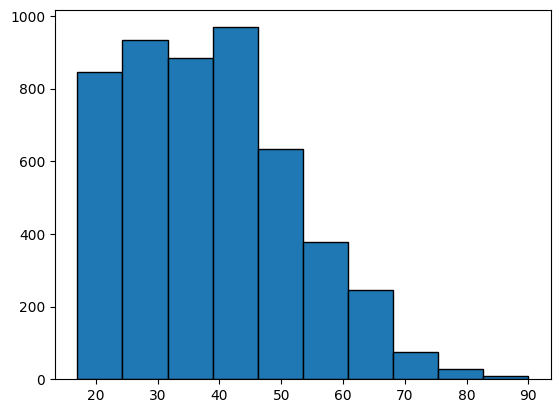

In [17]:
# hist only works for numerical variables
plt.hist(x=data['Age'].values, edgecolor='black')

In [18]:
data['Country of birth'].value_counts()

Country of birth
United-States                 4465
Mexico                         104
Canada                          28
Philippines                     22
Germany                         22
El-Salvador                     16
Puerto-Rico                     16
England                         16
Jamaica                         15
China                           15
Cuba                            14
Dominican-Republic              13
Italy                           12
India                           12
Iran                            11
Vietnam                         10
Taiwan                          10
Guatemala                       10
Poland                           9
South                            9
Japan                            9
Portugal                         7
Greece                           6
Haiti                            6
Columbia                         5
Nicaragua                        5
Trinadad&Tobago                  4
Ireland                          4
Ecu

<Axes: xlabel='Country of birth'>

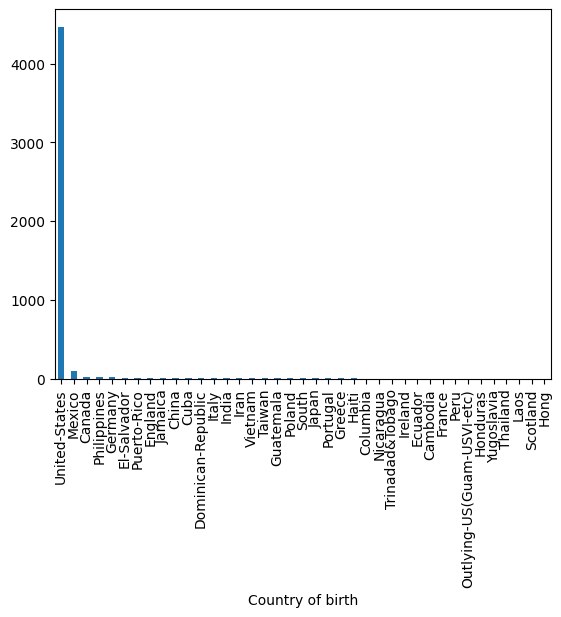

In [46]:
# value counts for categorical variables, use rot = 90 to rotate the x-axis labels by 90 degrees for readability
data['Country of birth'].value_counts().plot.bar(rot=90)

# 2. Exploratory Data Analysis

In [18]:
# how are the class labels distributed?
data['Income'].value_counts(normalize=True)
# class imbalance: use class_weigth attribute (eg randomforest has it) or Synthetic oversampling (SMOTE)

Income
0    0.7558
1    0.2442
Name: proportion, dtype: float64

<Axes: >

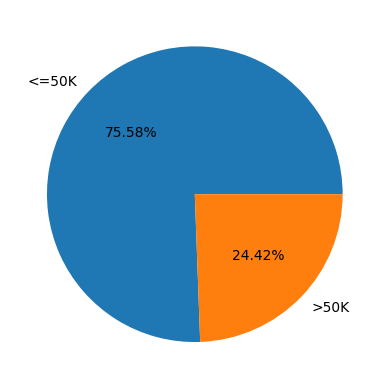

In [19]:
# visualized
pd.value_counts(data['Income']).plot(kind='pie',autopct='%1.2f%%', ylabel = '', labels = ['<=50K', '>50K',])

## 2.1 Imputation of missing Data

In [20]:
# Employment type
data['Employment type'].value_counts()
# lots of 'private' -> most frequent might be good imputer

Employment type
Private             3435
Self-emp-not-inc     383
Local-gov            329
State-gov            193
Self-emp-inc         182
Federal-gov          146
Without-pay            1
Name: count, dtype: int64

In [21]:
# Employment area
data['Employment area'].value_counts()
# more equally distributed ->  most frequent might NOT be good imputer -> KNN

Employment area
Prof-specialty       625
Craft-repair         619
Exec-managerial      618
Sales                588
Adm-clerical         576
Other-service        495
Machine-op-inspct    312
Transport-moving     247
Handlers-cleaners    196
Farming-fishing      143
Tech-support         140
Protective-serv       90
Priv-house-serv       18
Armed-Forces           2
Name: count, dtype: int64

In [22]:
# Country of birth
data['Country of birth'].value_counts()
# lots of 'united-states' -> most frequent might be good imputer

Country of birth
United-States                 4465
Mexico                         104
Canada                          28
Philippines                     22
Germany                         22
El-Salvador                     16
Puerto-Rico                     16
England                         16
Jamaica                         15
China                           15
Cuba                            14
Dominican-Republic              13
Italy                           12
India                           12
Iran                            11
Vietnam                         10
Taiwan                          10
Guatemala                       10
Poland                           9
South                            9
Japan                            9
Portugal                         7
Greece                           6
Haiti                            6
Columbia                         5
Nicaragua                        5
Trinadad&Tobago                  4
Ireland                          4
Ecu

In [23]:
# knn, complicated -> do later
#imputer_knn = KNNImputer()
#data_knn = copy.deepcopy(data)
#imputed_data = imputer_knn.fit_transform(data)  # impute all the missing data
#df_temp = pd.DataFrame(imputed_data)
#df_temp.columns = df.columns
#data['Employment type'] = df_temp['Employment type']  # update only the desired column

### 2.1.1 Simple imputer

In [9]:
# seeing how the simple imputer works
simple_imputer = SimpleImputer(strategy='most_frequent', copy = True, missing_values = np.nan)
imputed_data = pd.DataFrame(simple_imputer.fit_transform(data))
imputed_data.columns = data.columns
imputed_data.sample(25, random_state = 99)

,Age,Employment type,Weighting factor,Level of education,Schooling/training period,Martial status,Employment area,Partnership,Ethnicity,Gender,Gains on financial assets,Losses on financial assets,Weekly working time,Country of birth,Income
18212,20,Private,88231,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
3154,41,Private,119079,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,49,United-States,1
15570,42,Private,195755,HS-grad,9,Separated,Craft-repair,Unmarried,White,Male,0,0,40,United-States,0
22391,38,Private,331395,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,3942,0,84,Portugal,0
16225,57,Private,136107,9th,5,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,0
29871,40,Private,360884,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,50,United-States,0
21733,30,Private,231826,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,0
11315,66,Private,180211,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,30,Philippines,0
13642,34,Private,206609,Some-college,10,Never-married,Sales,Unmarried,White,Male,0,0,35,United-States,0
12069,20,Private,291979,HS-grad,9,Married-civ-spouse,Sales,Other-relative,White,Male,0,0,20,United-States,0


# 3. Train/Test split

In [12]:
# seperate the data
X = data.iloc[:, :14]
y = data.iloc[:, 14]
y = y.astype('int')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)

# 4. Model Selection

## 4.1 Pipeline

In [14]:
# proprocessing based on column types
pipe_cat = Pipeline([
    ('imp', SimpleImputer(strategy = 'most_frequent', missing_values = np.nan)),  
    ('encode', OneHotEncoder(handle_unknown='ignore')),  
])
# only categorical columns have missing values -> no imputation needed for numerical & binary columns
pipe_num = Pipeline([
    ('minmax', MinMaxScaler()),  
    ('stdscale', StandardScaler()),
])
pipe_bin = Pipeline([
    ('encode', OrdinalEncoder()),  
])
column_trans = ColumnTransformer(transformers = 
    [('cat', pipe_cat, categorical_features),                # categorical
    ('num', pipe_num, numerical_features),                   # numerical
    ('bin', pipe_bin, binary_features)])                     # binary/ordinal     
# show the column transformer
column_trans

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Employment type', 'Level of education',
                                  'Martial status', 'Employment area',
                                  'Partnership', 'Ethnicity',
                                  'Country of birth']),
                                ('num',
                                 Pipeline(steps=[('minmax', MinMaxScaler()),
                                                 ('stdscale',
                                                  StandardScaler())]),
                                 ['Age', 'Weighting factor',
                                  'Schooling/training period',
                                  'Gains on financial assets',
                                  'Losses on financial assets',
                                  'Weekly working time']),
                                ('bin',
                                 Pipeline(steps=[('encode', OrdinalEncoder())]),
                                 ['Gender'])])

In [27]:
# trying to get an output that can be looked at (difficult)
# solved below by chat gpt
# see here: https://stackoverflow.com/questions/70933014/how-to-use-columntransformer-to-return-a-dataframe
#column_trans.set_output('pandas')
#data_trans = pd.DataFrame(column_trans.fit_transform(data).toarray())
#data_trans.columns = data.columns
#data_trans.sample(25, random_state = 99)

ValueError: Length mismatch: Expected axis has 101 elements, new values have 15 elements

## 4.2 Random Forests

In [17]:
# random forest
pipe_rf = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99)) 
])
pipe_rf
# noch mehr details wie in vortag!

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', RandomForestClassifier(random_state=99))])

### 4.2.1 Hyperparameter tuning

In [18]:
# which parameters are there to tune?
print(pipe_rf.steps[0][1].get_params())

{'n_jobs': None, 'remainder': 'drop', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('cat', Pipeline(steps=[('imp', SimpleImputer(strategy='most_frequent')),
                ('encode', OneHotEncoder(handle_unknown='ignore'))]), ['Employment type', 'Level of education', 'Martial status', 'Employment area', 'Partnership', 'Ethnicity', 'Country of birth']), ('num', Pipeline(steps=[('minmax', MinMaxScaler()), ('stdscale', StandardScaler())]), ['Age', 'Weighting factor', 'Schooling/training period', 'Gains on financial assets', 'Losses on financial assets', 'Weekly working time']), ('bin', Pipeline(steps=[('encode', OrdinalEncoder())]), ['Gender'])], 'verbose': False, 'verbose_feature_names_out': True, 'cat': Pipeline(steps=[('imp', SimpleImputer(strategy='most_frequent')),
                ('encode', OneHotEncoder(handle_unknown='ignore'))]), 'num': Pipeline(steps=[('minmax', MinMaxScaler()), ('stdscale', StandardScaler())]), 'bin': Pipeline(steps=[('encode', Ordina

In [19]:
params_rf = {}
# n_estimators = number of trees used
# previously tested: [50, 100, 200] -> best = 200 -> AGAIN (bc at boundary) (all data), best = 100 (20% test split)
params_rf['classifier__n_estimators'] = [50, 100, 200]

# max_depth = maximum depth of each tree, 
# None = nodes are expanded until all number of samples in each leaf < min_samples_split
# previously tested: [None, 10, 20]-> best = None (all data), best = 10 (20% test split)
params_rf['classifier__max_depth'] = [None, 10, 20]

# min_samples_split = minimum number of samples required to split an internal node
# previously tested: [2, 5, 10] -> best = 10 -> AGAIN (bc at boundary) (all data), best = 5 (20% test split)
params_rf['classifier__min_samples_split'] = [2, 5, 10]

# min_samples_leaf = minimum number of samples required to be at a leaf node
# previously tested: [1, 2, 4] -> best = 2 (all data), best = 1 (20% test split)
params_rf['classifier__min_samples_leaf'] = [1, 2, 4]

# first iteration best score: 0.9083165385335306 (all data), score = 0.9135427084197859 (20% test split)

In [20]:
# -> use the best params and try again on the others (max_depth = None not needed since its the default)
pipe_rf = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99, min_samples_leaf = 2)) 
])
pipe_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2, random_state=99))])

In [52]:
params_rf2 = {}
# previously tested: [200, 350, 500] -> best = 500 -> AGAIN (bc at boundary)
params_rf2['classifier__n_estimators'] = [200, 350, 500]
# previously tested: [10, 15, 20] -> best = 20 -> AGAIN (bc at boundary)
params_rf2['classifier__min_samples_split'] = [10, 15, 20]
# previously tested: [None, 'balanced', {1: 76, 0: 24}] -> best = None
params_rf2['classifier__class_weight'] = [None, 'balanced', {1: 76, 0: 24}]

In [53]:
params_rf3 = {}
# previously tested: [500, 750, 1000] -> best = 500 -> AGAIN (to find exact number)
params_rf3['classifier__n_estimators'] = [500, 750, 1000]
# previously tested: [20, 30, 40] -> best = 40 -> AGAIN (bc at boundary)
params_rf3['classifier__min_samples_split'] = [20, 30, 40]

In [54]:
params_rf4 = {}
# previously tested: [500, 750, 1000] -> best = 400 -> AGAIN (to find exact number)
params_rf4['classifier__n_estimators'] = [400, 450, 500]
# previously tested: [40, 60, 80] -> best = 40 -> AGAIN (to find exact number)
params_rf4['classifier__min_samples_split'] = [40, 60, 80]

In [59]:
grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier',
                                        RandomForestClassifier(min_samples_leaf=2,
                                                               random_state=99))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [61]:
# what was the best AUC score
grid_rf.best_score_

0.9135427084197859

In [62]:
# which parameters where used to get that score
grid_rf.best_params_

{'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100}

In [60]:
# how much time (in minutes) did the gridCV take ~15min (all data) ~9mins (20% test split)
mean_fit_time= grid_rf.cv_results_['mean_fit_time']
mean_score_time= grid_rf.cv_results_['mean_score_time']
n_splits  = grid_rf.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(grid_rf.cv_results_).shape[0] #Iterations per split

print((np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)/60)

8.819040656089783


### 4.2.2 Final Random Forest

In [22]:
# -> use the best params and try again on the others (max_depth = None not needed since its the default)
# OLD: with all data
#pipe_rf_final = Pipeline([
#    ('preprocessor', column_trans),
#    ('classifier', RandomForestClassifier(random_state=99, min_samples_leaf = 2, n_estimators = 400,
#                                         min_samples_split = 40)) 
#])
# NEW: 20% test data
pipe_rf_final = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', RandomForestClassifier(random_state=99, min_samples_leaf = 1, n_estimators = 100,
                                         min_samples_split = 5)) 
])

## 4.3 Logistic Regression

In [106]:
# logistic regression
pipe_log = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', LogisticRegression(random_state=99)) 
])
pipe_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier', LogisticRegression(random_state=99))])

## 4.3.1 Hyperparameter tuning

In [125]:
params_log = {}
# solver = ?
# previously tested: [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’] -> best = 'liblinear'
params_log['classifier__solver'] = ['newton-cg', 'lbfgs', 'liblinear']

# penalty = ?
# previously tested: [‘none’, ‘l1’, ‘l2’, ‘elasticnet’] -> best = 'l1'
params_log['classifier__penalty'] = ['l2', 'l1', 'none', 'elasticnet']

# C = ?
# previously tested: [0.1, 1, 10] -> best = 1 
params_log['classifier__C'] = [00.1, 0.1, 1, 10, 100]

# max_iter = ?
# previously tested: [100, 1000, 10000] -> best = 100 
params_log['classifier__max_iter'] = [10, 100, 1000, 10000]

# first iteration best score: 0.9026366008095295 (20% test split)

In [126]:
grid_log = GridSearchCV(pipe_log, params_log, cv=5, scoring = 'roc_auc')
grid_log.fit(X_train, y_train)

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  w

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: Futur

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep t

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  w

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\s

C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Employment '
                                                                          'type',
                                                                          'Level '
                                                                          'of '
                                                                          'education',
                                                                          'Martial '
                                                                          'status',
                                                                          'Employment '
                                                                          'area',
                                                                          'Partnership',
                                                                          'Ethnicity',
                                                                          'Country '
                                                                          'of '
                                                                          'birth']),
                                                                        ('num'...
                                                                          'working '
                                                                          'time']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encode',
                                                                                          OrdinalEncoder())]),
                                                                         ['Gender'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=99))]),
             param_grid={'classifier__C': [0.1, 0.1, 1, 10, 100],
                         'classifier__max_iter': [10, 100, 1000, 10000],
                         'classifier__penalty': ['l2', 'l1', 'none',
                                                 'elasticnet'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear']},
             scoring='roc_auc')

In [127]:
# what was the best AUC score
grid_log.best_score_

0.9026366008095295

In [128]:
# which parameters where used to get that score
grid_log.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

### 4.3.2 Final Logistic Regression

In [21]:
pipe_log_final = Pipeline([
    ('preprocessor', column_trans),
    ('classifier', LogisticRegression(random_state=99, C = 1, max_iter = 100, penalty = 'l1', solver = 'liblinear')) 
])

# 5. Model evaluation

## 5.1 Random Forests

In [28]:
X = data.iloc[:, :14]
y = data.iloc[:, 14]
y = y.astype('int')

In [23]:
pipe_rf_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, random_state=99))])

In [24]:
pipe_log_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 LogisticRegression(C=1, penalty='l1', random_state=99,
                                    solver='liblinear'))])

In [25]:
# get the probability scores for each class, select the class with the "greater label" (in this case 1) 
# by using predict_proba(X_test)[:,1] (see sklearn doc: 3.3.2.15. Receiver operating characteristic (ROC) -> binary)
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules
y_score_rf = pipe_rf_final.predict_proba(X_test)[:,1]
y_score_log = pipe_log_final.predict_proba(X_test)[:,1]

In [26]:
# let the auc score be calculated
auc_rf = roc_auc_score(y_test, y_score_rf)
print(auc_rf)

0.8823598991349044


In [27]:
# let the auc score be calculated
auc_log = roc_auc_score(y_test, y_score_log)
print(auc_log)

0.8845428004580866


In [29]:
# OLD
# random forest with custom class weight
score_rf = cross_val_score(pipe_rf_final, X, y, cv=5, scoring = 'roc_auc')
print(score_rf)

[0.90932648 0.90051175 0.91237857 0.89962269 0.92163806]


In [30]:
print('Mean ROC AUC: %.4f' %(score_rf.mean()))

Mean ROC AUC: 0.9087


In [41]:
print('Mean ROC AUC: %.4f' %(score_rf2.mean()))
# better score for rf with class weights (0.8948177888255628) than without (0.8941253106497186)

Mean ROC AUC: 0.8941


## 5.2 Logistic Regression

## 5.X Precision-Recall Curves

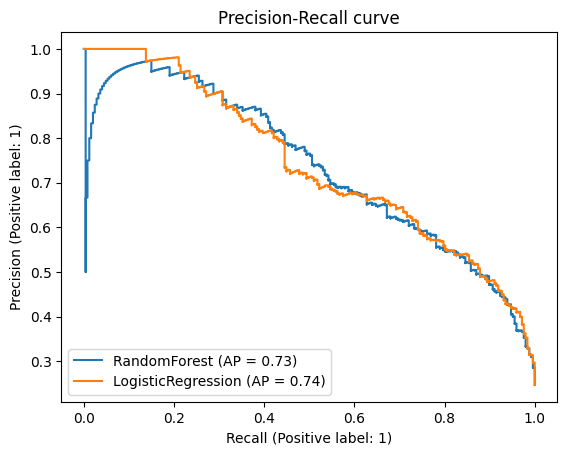

In [31]:
fig, ax = plt.subplots()
#PrecisionRecallDisplay.from_predictions(y_train, y_pred_train, ax=ax)
#PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax)
PrecisionRecallDisplay.from_predictions(
     y_test, y_score_rf, name="RandomForest", ax=ax)
PrecisionRecallDisplay.from_predictions(
     y_test, y_score_log, name="LogisticRegression", ax=ax)
ax.set_title("Precision-Recall curve")
plt.show()

In [43]:
# note that these curves use the full 5000 data points, not a train/test split
grid_rf_predictions = grid_rf.predict(X)
#grid_rf_probs = grid_rf.decision_function(X)

In [44]:
print(confusion_matrix(y, grid_rf_predictions))
print('\n')
print(classification_report(y, grid_rf_predictions))

NameError: name 'confusion_matrix' is not defined

In [32]:
plt.plot(grid_rf_final_recall, grid_rf_Final_precision, label="RF (tuned), AUC={}".format(grid_rf_final_auc))
#plt.plot(nb_recall, nb_precision,label="Naive Bayes, AUC={}".format(auc_nb))
#plt.plot(grid_log_recall, grid_log_precision, label="Logistic Regression (tuned), AUC={}".format(grid_log_auc))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()

NameError: name 'grid_rf_final_recall' is not defined

### 3.1.1 Feature importances

In [31]:
# fit the rf3 in order to get feature importances
pipe_rf_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Employment type',
                                                   'Level of education',
                                                   'Martial status',
                                                   'Employment area',
                                                   'Partnership', 'Ethnicity',
                                                   'Country of birth']),
                                                 ('num',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler()),
                                                                  ('stdscale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Weighting factor',
                                                   'Schooling/training period',
                                                   'Gains on financial assets',
                                                   'Losses on financial assets',
                                                   'Weekly working time']),
                                                 ('bin',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder())]),
                                                  ['Gender'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2,
                                        min_samples_split=40, n_estimators=400,
                                        random_state=99))])

In [57]:
# and access the feature importances
pipe_rf_final.named_steps['classifier'].feature_importances_
# HOWEVER, there are 101 features due to the one hot encoder

array([5.11096757e-03, 5.85619545e-03, 1.35804768e-02, 6.30435759e-03,
       8.55693564e-03, 5.60279236e-03, 5.67295777e-06, 3.07455565e-03,
       3.55393745e-03, 1.13012914e-03, 3.56763548e-04, 6.87151271e-04,
       2.38204511e-03, 2.32343577e-03, 3.00063894e-03, 3.66620520e-03,
       1.03949467e-02, 2.70797203e-03, 1.01554961e-02, 5.82077583e-03,
       4.48633420e-05, 4.23560938e-03, 8.07095654e-03, 8.26701966e-03,
       1.14410310e-04, 7.81555741e-02, 1.77799146e-03, 3.66645292e-02,
       2.81592024e-03, 2.49825046e-03, 9.21135166e-03, 0.00000000e+00,
       9.62030097e-03, 1.56241670e-02, 4.98286821e-03, 4.30346114e-03,
       5.79517885e-03, 9.29908791e-03, 1.06303774e-04, 1.27421481e-02,
       2.77924046e-03, 8.71923181e-03, 5.51324884e-03, 6.51016333e-03,
       4.51716958e-02, 1.79477582e-02, 1.73399071e-03, 1.76825234e-02,
       9.50703612e-03, 1.39420495e-02, 1.68143592e-03, 3.89781961e-03,
       6.86714498e-03, 9.38563042e-04, 8.97105163e-03, 3.04029686e-04,
      

In [74]:
pipe_rf_final.steps

[('preprocessor',
  ColumnTransformer(transformers=[('cat',
                                   Pipeline(steps=[('imp',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('encode',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                   ['Employment type', 'Level of education',
                                    'Martial status', 'Employment area',
                                    'Partnership', 'Ethnicity',
                                    'Country of birth']),
                                  ('num',
                                   Pipeline(steps=[('minmax', MinMaxScaler()),
                                                   ('stdscale',
                                                    StandardScaler())]),
                                   ['Age', 'Weighting factor',
                                    '

In [59]:
feature_importances = zip(dv.feature_names_, pipe_rf3.named_steps['classifier'].feature_importances_)

NameError: name 'dv' is not defined

In [60]:
from scipy.sparse import issparse

# Transform the original data using the preprocessing pipeline (excluding the classifier)
X_transformed = pipe_rf.named_steps['preprocessor'].transform(X)

# Check if X_transformed is a sparse matrix
if issparse(X_transformed):
    # Convert the sparse matrix to a dense NumPy array
    X_transformed = X_transformed.toarray()

# Convert the transformed data to a DataFrame without specifying columns
X_transformed_df = pd.DataFrame(X_transformed)

# Add the 'Income' column back to the DataFrame if needed
X_transformed_df['Income'] = data['Income']  # Assuming 'Income' is the target column

# Inspect the shape of the transformed DataFrame
print(X_transformed_df.shape)

# Inspect the first few rows of the transformed DataFrame
print(X_transformed_df.head())

X_transformed_df.isna().sum() 

(5000, 102)
     0    1    2    3    4    5    6    7    8    9  ...   92   93        94   
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.029411  \
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.838632   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0 -0.044154   
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  1.059328   
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0 -0.779809   

         95        96        97        98        99  100  Income  
0 -1.064913  1.152189  0.161728 -0.228106 -0.042864  1.0       0  
1 -1.010422  1.152189 -0.146593 -0.228106 -2.272798  1.0       0  
2  0.233924 -0.425936 -0.146593 -0.228106 -0.042864  1.0       0  
3  0.413286 -1.214999 -0.146593 -0.228106 -0.042864  1.0       0  
4  1.388265  1.152189 -0.146593 -0.228106 -0.042864  0.0       0  

[5 rows x 102 columns]


0         0
1         0
2         0
3         0
4         0
         ..
97        0
98        0
99        0
100       0
Income    0
Length: 102, dtype: int64

In [61]:
print(X_transformed.shape)

(5000, 101)


In [62]:
y.value_counts()

Income
0    3779
1    1221
Name: count, dtype: int64

In [63]:
print(y.unique())

[0 1]


In [64]:
y.dtype

dtype('int32')

In [65]:
data['Income'].dtype

dtype('O')